In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Logistic Regression

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, std

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    GridSearchCV,
    cross_val_score,
)

# Scoring the Models
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from yellowbrick.classifier import ROCAUC

<IPython.core.display.Javascript object>

1) Benchmark for Multinomial LogReg
pre RFE
2) Run Grid Search for Multinomial 
3) Hypertune Multinomial
4) Run Grid Search for OVO
5) Hypertune OVO
Subplot to compare side by side ROCAUC Curves (not in YellowBrick)
post RFE
2) Run Grid Search for Multinomial 
3) Hypertune Multinomial
4) Run Grid Search for OVO
5) Hypertune OVO
Subplots to compare Classification Reports

In [3]:
df = pd.read_csv("../14_profiles/reduced_dim_14.csv")
df

,profile_standardized,.NET,.NET Core,API,API Design,APIs,ASP.NET,ASP.NET MVC,AWS,AWS DynamoDB,...,Xamarin,Xamarin Forms,Xcode,Zend Framework,iOS,iOS Operating System,iOS SDK,iPad,jQuery,js
0,fullstack developer,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,javascript developer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,machine learning engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,machine learning engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,android developer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,fullstack developer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767,machine learning engineer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
768,ios developer,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
769,javascript developer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [4]:
# Generating X (feature) variable & y (target) variable
X = df.iloc[:, 1:]
y = df.profile_standardized

<IPython.core.display.Javascript object>

In [5]:
# Splitting the data to a train and test set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

# Benchmark for Multinomial Logistic Regression Algorithm Performance

‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’. In order to ensure that all iterations are treated as a multi-class problem when we run grid search, we pass multinomial to the multi-class argument.

In [6]:
# Instantiate the LogisticRegression Object
lr = LogisticRegression(random_state=0, multi_class="multinomial")
# Fit the model to the training data
lr.fit(X_train, y_train)
# Make predictions using the testing data
y_pred = lr.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: {:.2f}".format(
        lr.score(X_test, y_test)
    )
)

Accuracy of logistic regression classifier on test set: 0.57


<IPython.core.display.Javascript object>

 # Implement Multinomial Grid Search : allows testing of multiple hyperparameters at once

In [7]:
# Hyperparameters to tune across both Multinomial & OVO classification problems
solver_list = ["liblinear", "newton-cg", "lbfgs", "sag", "saga"]
penalty = ["none", "l1", "l2", "elasticnet"]
c_values = [100, 10, 1.0, 0.1, 0.01]

<IPython.core.display.Javascript object>

In [8]:
grid = dict(solver=solver_list, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=grid,
    n_jobs=-1,  # indicates all processors should be used
    cv=cv,
    scoring="accuracy",
    error_score=0,
)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<IPython.core.display.Javascript object>

# Hyperparameter explanation
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

Essentially all parameters tuned here have to do with regularization. Regularization shifts the model toward the bias side of things in the bias/variance tradeoff, which makes for a more generalizable logistic regression model. A more generalizable model is one which can be generalized to new data, and therefore performs better with new, unseen data. A less generalizable model will be more fit to that particular problem's training data, and will not perform as well with new, unseen data.

1) C is a penalty term, meant to disincentivize and regulate against overfitting. Too big a C value will over-regulate and cause overfitting, while too small a C value will under-regulate and cause underfitting.

2) L1 Regularization uses Lasso Regression which shrinks the less important feature's coefficients to zero, thus completely removing some features. This works well for feature seletion with a huge number of features, as we have here.

3) The 'saga' solver supports L1 Regularization, and is the solver of choice for sparse multinomial logistic regression problems like this one. It's also well suited to large datasets. When using the sag and saga solvers, make sure features are on a similar scale. As the problem set's features have been converted to indicator variables, there is no need to scale them.

C:\Users\oefel\.virtualenvs\Celerative_Working-MkC17mr_\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

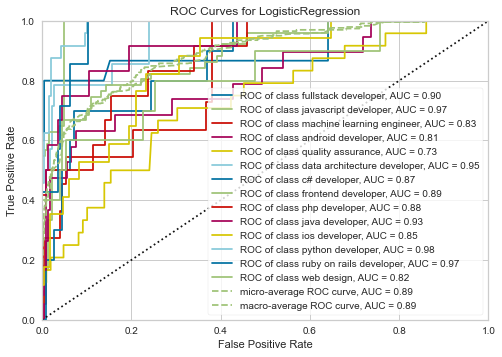

<IPython.core.display.Javascript object>

In [9]:
visualizer = ROCAUC(
    lr,
    classes=[
        "fullstack developer",
        "javascript developer",
        "machine learning engineer",
        "android developer",
        "quality assurance",
        "data architecture developer",
        "c# developer",
        "frontend developer",
        "php developer",
        "java developer",
        "ios developer",
        "python developer",
        "ruby on rails developer",
        "web design",
    ],
)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show("multinomial.png")

# Benchmark for OVO Logistic Regression Algorithm Performance

In [10]:
from sklearn.multiclass import OneVsOneClassifier

# define model
model = LogisticRegression(random_state=0)
# define ovo strategy
ovo = OneVsOneClassifier(model)
# fit model
ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(random_state=0))

<IPython.core.display.Javascript object>

In [11]:
# make predictions
yhat = ovo.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: {:.2f}".format(
        ovo.score(X_test, y_test)
    )
)

Accuracy of logistic regression classifier on test set: 0.54


<IPython.core.display.Javascript object>

# Benchmark for OVR Logistic Regression Algorithm Performance

In [12]:
from sklearn.multiclass import OneVsRestClassifier

# define model
model = LogisticRegression(random_state=0)
# define ovo strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=0))

<IPython.core.display.Javascript object>

In [14]:
# make predictions
yhat = ovr.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: {:.2f}".format(
        ovr.score(X_test, y_test)
    )
)

Accuracy of logistic regression classifier on test set: 0.58


<IPython.core.display.Javascript object>

# Grid Search cannot be implemented with OVO as params are preset. See get_params() output:

In [ ]:
ovo.get_params()

We can't run roc_cuve function or run gridsearch with ovo and ovr methods. So we will manipulate the data to create a binary problem in order to run these grid search and roc_curve methods.

# Manipulate the Data to convert JavaScript Developer to Binary (indicator) Variable

In [16]:
df["profile_standardized"].value_counts(normalize=True)

javascript developer           0.178988
quality assurance              0.111543
frontend developer             0.094682
fullstack developer            0.086900
machine learning engineer      0.068742
android developer              0.068742
python developer               0.062257
php developer                  0.060960
ios developer                  0.060960
java developer                 0.058366
web design                     0.055772
c# developer                   0.031128
ruby on rails developer        0.031128
data architecture developer    0.029831
Name: profile_standardized, dtype: float64

<IPython.core.display.Javascript object>

In [17]:
# Convert target class to binary variable,
# which allows us to treat this as a One V. Rest classification problem
df["javascript developer"] = np.where(
    df["profile_standardized"] == "javascript developer", 1, 0
)

<IPython.core.display.Javascript object>

In [18]:
# Generate X (feature) variable & y (target) variable
X = df.iloc[:, 1:-1]
y = df["javascript developer"]

<IPython.core.display.Javascript object>

In [19]:
# Splitting the data to a train and test set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

# Benchmark manipulated Data

In [27]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: ",
    np.mean(cross_val_score(model, X_test, y_test, scoring="roc_auc", cv=10)),
)

Accuracy of logistic regression classifier on test set:  0.9181091617933724


<IPython.core.display.Javascript object>

# GridSearch manipulated data

In [ ]:
grid = dict(solver=solver_list, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid,
    n_jobs=-1,
    cv=cv,
    scoring="accuracy",
    error_score=0,
)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

With L2 regularization, a sparse matrix will get small, but will not go to 0 as it will with L1 regularization.
The liblinear solver performs well with high dimensionality, which could explain why it was selected here! However the it's also the only solver to penalize the intercept, which isn't good for interpretation.

In [ ]:
# Predict probabilities for Binary Problem
y_score = model.predict_proba(X_test)[:, 1]
# False Positive & True Postive rates to be used to plot the ROC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

In [ ]:
plt.subplots(1, figsize=(8, 8))
plt.title("Receiver Operating Characteristic (ROC) : Logistic regression")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.savefig("binary.jpg")
plt.close()

Scikit-Learn does not actually support the roc_curve metric for multi-class classification, as this is usually only used with binary classifiers. Yellowbrick addresses this by binarizing the output (per-class) or to use one-vs-rest (micro score) or one-vs-all (macro score) strategies of classification.

**binary : roc_auc = 0.9181091617933724** ![](binary.jpg) **multinomial : roc_auc = 0.89** ![](multinomial.png)